###Imports from commit felipe:

In [ ]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, GridSearchCV

###The rest of the imports I haven't added to the file (you need to add them)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor
from time import time
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
!pip install catboost 
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
!pip install shap
import shap
import seaborn as sns
from sklearn.inspection import permutation_importance
import timeit
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 18.2 MB/s eta 0:00:00


In [ ]:
# Grid search to find best parameters
def gridsearch(df, model, params, features, target, score = 'neg_mean_squared_error'):
  # clf = RandomizedSearchCV(estimator = model,
  #                        param_distributions = params,
  #                        scoring = score,
  #                        n_iter=3,
  #                        verbose=1)
  clf = GridSearchCV(estimator = model,
                         param_grid = params,
                         scoring = score, cv=2,
                         verbose=1)
  clf.fit(df[features], target)
  
  print("Best parameters:", clf.best_params_)
  print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

  return clf.best_params_, (-clf.best_score_)**(1/2.0)

In [ ]:
# Example for testing, but we do need to define features and target somehow
df = pd.read_csv("CleanedData.csv")
df2 = df.drop(columns=['host_id', 'id', 'name', 'host_name', 'last_review'])
df2=df2.dropna().reset_index(drop=True) # we drop na only 1 row
features = [col for col in df2.columns if col != "price"] #changed it so the indexes don't matter
target = df2["price"] 
print("features", features)

FileNotFoundError: ignored

In [ ]:
###Mount google drive:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

MessageError: ignored

In [ ]:
###This is to run the CleanedData uploaded in the shared drive(was having issues with my own file)4
df = pd.read_csv("/content/gdrive/Shareddrives/Ensemble Learning/CleanedData.csv")
df2 = df.drop(columns=['host_id', 'id', 'name', 'host_name', 'last_review'])
df2=df2.dropna().reset_index(drop=True) # we drop na only 1 row
features = [col for col in df2.columns if col != "price"] #changed it so the indexes don't matter
target = df2["price"] 
print("features", features)

##Simple Trees + Bagging

###Regression Tree

(best_model: DecisionTreeRegressor(ccp_alpha=0, max_depth=8, min_samples_leaf=4,
                      random_state=42)
Best Parameters: {'ccp_alpha': 0, 'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 2}
RMSE: 0.4193418074015745
R-squared: 0.596131506000871
Mean squared error: 0.17584755143481923


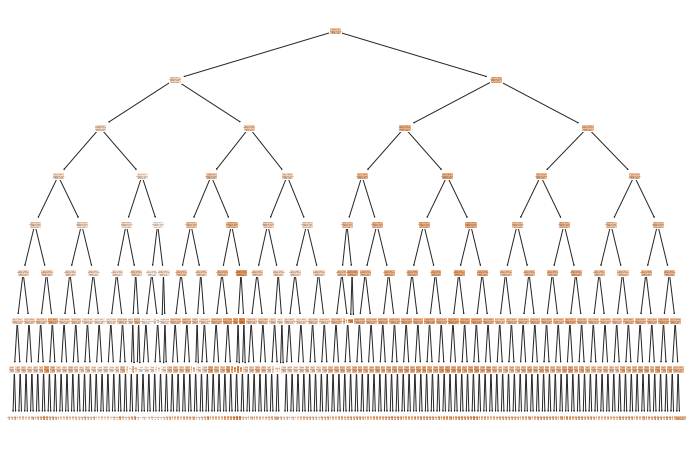

In [ ]:


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df2[features], target, test_size=0.2, random_state=10)

# Initialize model
model = DecisionTreeRegressor(random_state=42)

# Define hyperparameters for grid search
#This grid takes a while to run, I got 0.58 on the other grid search which takes like a 1 minute.
#This grid should improve performance slighly
# params = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#           'min_samples_split': [2, 5, 10],
#           'min_samples_leaf': [1, 2, 4, 8],
#           'max_leaf_nodes': [None, 2, 5, 10, 20],
#           'ccp_alpha': [0, 0.01, 0.1, 1, 10]} #for regularization purposes

          # Define the parameter grid
params = {'max_depth': [2, 5, 8],
          'min_samples_split': [2, 5],
          'min_samples_leaf': [1, 4],
          'ccp_alpha': [0, 0.1, 1]}

# Perform grid search to find best hyperparameters
grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print('(best_model:',best_model)
best_params = grid_search.best_params_
# Fit best model to data
best_model.fit(X_train, y_train)

# Make predictions on test data
y_pred = best_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("RMSE:", rmse)
print("R-squared:", r2)
print("Mean squared error:", mse)

# Plot decision tree
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 8))
plot_tree(best_model, filled=True)
plt.show()

# Best Parameters: {'ccp_alpha': 0, 'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 2}
# RMSE: 0.4193418074015745
# R-squared: 0.596131506000871
# Mean squared error: 0.17584755143481923

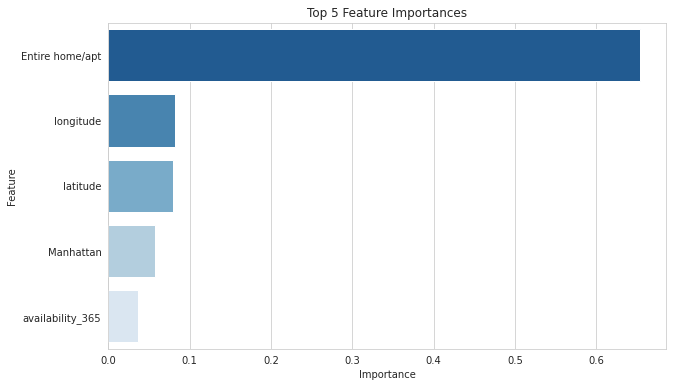

Training R^2: 0.6294788276625701
Testing R^2: 0.596131506000871
Training Explained Variance Score: 0.6294788276625701
Testing Explained Variance Score: 0.5961949120432395
Training Mean Absolute Error: 0.30170684410977733
Testing Mean Absolute Error: 0.31511513846301425
Training Mean Squared Error: 0.16057548132114552
Testing Mean Squared Error: 0.17584755143481923


In [ ]:
# Visualize feature importance
import seaborn as sns

# Get feature importances
importances = best_model.feature_importances_
features = X_train.columns

# Create dataframe of feature importances
feature_importances = pd.DataFrame({'feature': features, 'importance': importances})

# Sort features by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot feature importances
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(5), palette='Blues_r')
plt.title('Top 5 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Print other evaluation metrics
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

train_explained_variance = explained_variance_score(y_train, y_pred_train)
test_explained_variance = explained_variance_score(y_test, y_pred_test)

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

print("Training R^2:", train_r2)
print("Testing R^2:", test_r2)
print("Training Explained Variance Score:", train_explained_variance)
print("Testing Explained Variance Score:", test_explained_variance)
print("Training Mean Absolute Error:", train_mae)
print("Testing Mean Absolute Error:", test_mae)
print("Training Mean Squared Error:", train_mse)
print("Testing Mean Squared Error:", test_mse)


###Bagging

In [ ]:


# Define the base estimator (i.e. decision tree)
base_estimator = DecisionTreeRegressor(random_state=42)

# Define the parameter grid for the bagging
##This grid takes a bit of time... at least 20 mins.
# params = {
#     'n_estimators': [10, 50, 100, 200],
#     'max_samples': [0.5, 1.0],
#     'max_features': [0.5, 1.0],
#     'bootstrap': [True, False],
#     'bootstrap_features': [True, False]
# }

##Used this smaller gridsearch for the last run in the end it took a while too but 
params = {
    'n_estimators': [200],
    'max_samples': [0.5, 1.0],
    'max_features': [1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}
# Define the bagging regressor
bagging = BaggingRegressor(estimator=base_estimator, n_estimators=100, random_state=42)

# Define the grid search
grid_search = GridSearchCV(estimator=bagging, param_grid=params, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best estimator and its hyperparameters
best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_
print('Best model:', best_estimator)

print('Best hyperparameters:', best_params)

# Train the best estimator on the training data
best_estimator.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = best_estimator.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("RMSE:", rmse)
print("R-squared:", r2)
print("Mean squared error:", mse)

##May be better if I increase the number of estimators
# Best model: BaggingRegressor(bootstrap_features=True,
#                  estimator=DecisionTreeRegressor(random_state=42),
#                  n_estimators=200, random_state=42)
# Best hyperparameters: {'bootstrap': True, 'bootstrap_features': True, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}
# RMSE: 0.39171586212746884
# R-squared: 0.6475918318798668
# Mean squared error: 0.15344131664226618

Best model: BaggingRegressor(bootstrap_features=True,
                 estimator=DecisionTreeRegressor(random_state=42),
                 n_estimators=200, random_state=42)
Best hyperparameters: {'bootstrap': True, 'bootstrap_features': True, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}
RMSE: 0.39171586212746884
R-squared: 0.6475918318798668
Mean squared error: 0.15344131664226618


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


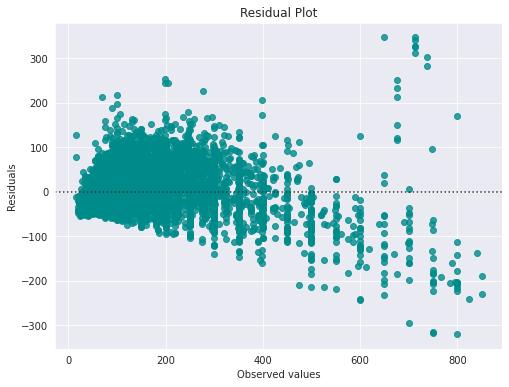

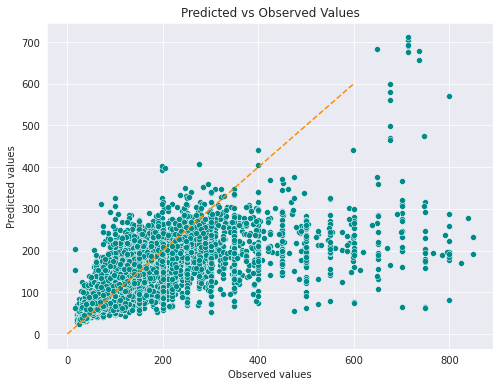

In [ ]:
# # Plot feature importance??

# Plot residual plot
sns.set_style('darkgrid')
plt.figure(figsize=(8,6))
sns.residplot(np.exp(y_test), np.exp(y_pred), color='darkcyan')
plt.title('Residual Plot')
plt.xlabel('Observed values')
plt.ylabel('Residuals')
plt.show()

# Plot predicted vs observed values
sns.set_style('darkgrid')
plt.figure(figsize=(8,6))
sns.scatterplot(np.exp(y_test), np.exp(y_pred), color='darkcyan')
plt.plot([0, 600], [0, 600], linestyle='--', color='darkorange')
plt.title('Predicted vs Observed Values')
plt.xlabel('Observed values')
plt.ylabel('Predicted values')
plt.show()


In [ ]:
##Increasing the N_estimators gives me marginally better results ~.649
# Define the base estimator (i.e. decision tree)
base_estimator = DecisionTreeRegressor(random_state=42)

# Define the bagging regressor with your desired hyperparameters
bagging = BaggingRegressor(estimator=base_estimator, 
                           n_estimators=300, 
                           max_samples=1.0, 
                           max_features=1.0, 
                           bootstrap=True, 
                           bootstrap_features=True,
                           random_state=42)

# Fit the bagging regressor to the training data
bagging.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = bagging.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("RMSE:", rmse)
print("R-squared:", r2)
print("Mean squared error:", mse)


RMSE: 0.39092718408567373
R-squared: 0.6490094757027518
Mean squared error: 0.15282406325715425


estimators:0*10: 0.17284349570921395
estimators:1*10: 0.1610625281226009
estimators:2*10: 0.1601358918085003
estimators:3*10: 0.15941014108989007
estimators:4*10: 0.15817128587797946
estimators:5*10: 0.15729408875036424
estimators:6*10: 0.15665269373707255
estimators:7*10: 0.15523557614812827
estimators:8*10: 0.15483090504936
estimators:9*10: 0.15495548868431744
estimators:10*10: 0.1548274388846097
estimators:11*10: 0.15481318239967784
estimators:12*10: 0.15454933559281767
estimators:13*10: 0.15445991809996962
estimators:14*10: 0.1541104486746511
estimators:15*10: 0.15397921333690717
estimators:16*10: 0.15361739561790458
estimators:17*10: 0.15362616489300202
estimators:18*10: 0.15353018614996097
estimators:19*10: 0.15344131664226618
estimators:20*10: 0.15333211725747928
estimators:21*10: 0.15323805287710673
estimators:22*10: 0.1531524313103057
estimators:23*10: 0.15313030200832933
estimators:24*10: 0.15305881210351133
estimators:25*10: 0.15296813308756868
estimators:26*10: 0.1528470530

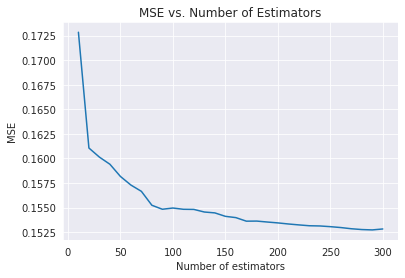

In [ ]:
##Maybe we can use this code to check how much N_estimators affects performance
##From my understanding, in general more estimators is better but it eventually stabilizies in the return so with this we should be able to check for N_estimators instead of putting in the grid search.
##Training all the models for N_estimators takes a while so might be smarter to shorten the range.
N = 30
mse = np.zeros(N)

for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(df2[features], target, test_size=0.2, random_state=10)
    reg = BaggingRegressor(estimator=DecisionTreeRegressor(), 
                            max_samples=1.0,
                            max_features=1.0, 
                            n_estimators=(i+1)*10,
                            bootstrap=True, 
                            bootstrap_features=True, 
                            random_state=42)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    mse[i] = mean_squared_error(y_test, y_pred)
    print(f'estimators:{i}*10:',mse[i])


plt.plot([10*(i+1) for i in range(30)], mse)
plt.xlabel("Number of estimators")
plt.ylabel("MSE")
plt.title("MSE vs. Number of Estimators")
plt.show()

##Random Forest + Extra RF + Gradient Boosting

### Random Forest

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df2[features], target, test_size=0.2, random_state=10)

# Initialize model
rf_model = RandomForestRegressor(random_state = 27)

# Define hyperparameters for grid search
# Define the parameter grid
params = { 'max_depth': [5, 7, 10],
           'n_estimators': np.arange(220, 240, 10),
          'min_samples_split': [5],
          'max_features': [0.3, 0.5, 0.7]
          }

# Perform grid search to find best hyperparameters
grid_search = GridSearchCV(rf_model, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print('(best_model:',best_model)
best_params = grid_search.best_params_

# Fit best model to data
best_model.fit(X_train, y_train)

# Make predictions on test data
y_pred = best_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("RMSE:", rmse)
print("R-squared:", r2)
print("Mean squared error:", mse)

# Best Parameters: {'max_depth': 10, 'max_features': 0.7, 'min_samples_split': 5, 'n_estimators': 220}
# RMSE: 80.40434550004741
# R-squared: 0.4536494693930212
# Mean squared error: 6464.858775290994

(best_model: RandomForestRegressor(max_depth=10, max_features=0.7, min_samples_split=5,
                      n_estimators=220, random_state=27)
Best Parameters: {'max_depth': 10, 'max_features': 0.7, 'min_samples_split': 5, 'n_estimators': 220}
RMSE: 0.39714367957434654
R-squared: 0.6377578689889438
Mean squared error: 0.15772310222585123


In [ ]:
# Evaluate model performance on real price
mse = mean_squared_error(y_test.apply(lambda x: math.exp(x)), pd.Series(y_pred).apply(lambda x: math.exp(x)))
rmse = np.sqrt(mse)
r2 = r2_score(y_test.apply(lambda x: math.exp(x)), pd.Series(y_pred).apply(lambda x: math.exp(x)))

In [ ]:
print("RMSE:", rmse)
print("R-squared:", r2)
print("Mean squared error:", mse)

RMSE: 80.40434550004741
R-squared: 0.4536494693930212
Mean squared error: 6464.858775290994


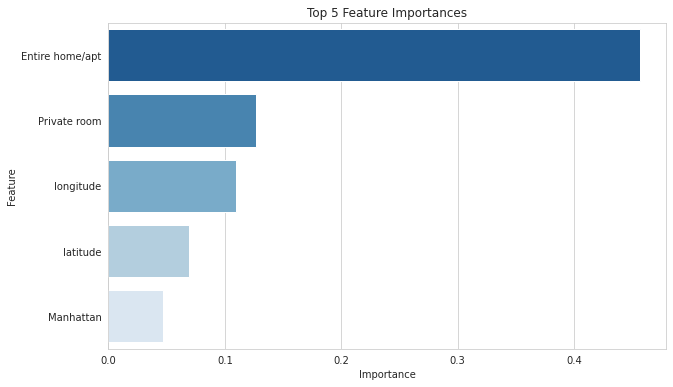

In [ ]:
# Feature Importance
import seaborn as sns

# Get feature importances
importances = best_model.feature_importances_
features = X_train.columns

# Create dataframe of feature importances
feature_importances = pd.DataFrame({'feature': features, 'importance': importances})

# Sort features by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot feature importances
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(5), palette='Blues_r')
plt.title('Top 5 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

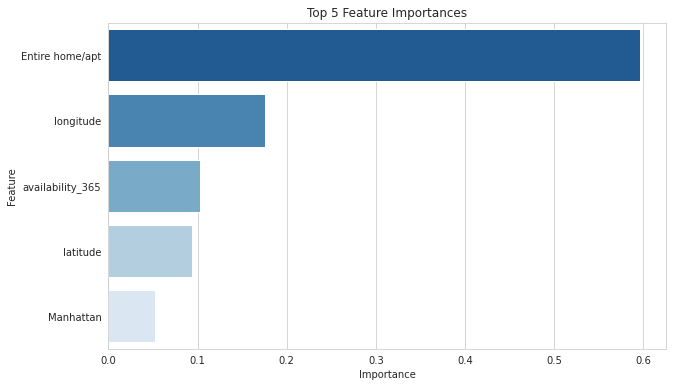

Training R^2: 0.6983153183983345
Testing R^2: 0.6379771784705688
Training Explained Variance Score: 0.6983154622723484
Testing Explained Variance Score: 0.6380046274917577
Training Mean Absolute Error: 0.2736460019562954
Testing Mean Absolute Error: 0.29804556474462507
Training Mean Squared Error: 0.13074330584079896
Testing Mean Squared Error: 0.1576276131349139


In [ ]:
# Visualize feature importance

# Get feature importances
result = permutation_importance(best_model, X_train, y_train, n_repeats=10, random_state=0)
importances = result.importances_mean
features = X_train.columns

# Create dataframe of feature importances
feature_importances = pd.DataFrame({'feature': features, 'importance': importances})

# Sort features by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot feature importances
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(5), palette='Blues_r')
plt.title('Top 5 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Print other evaluation metrics
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

train_explained_variance = explained_variance_score(y_train, y_pred_train)
test_explained_variance = explained_variance_score(y_test, y_pred_test)

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

print("Training R^2:", train_r2)
print("Testing R^2:", test_r2)
print("Training Explained Variance Score:", train_explained_variance)
print("Testing Explained Variance Score:", test_explained_variance)
print("Training Mean Absolute Error:", train_mae)
print("Testing Mean Absolute Error:", test_mae)
print("Training Mean Squared Error:", train_mse)
print("Testing Mean Squared Error:", test_mse)


### Extreme Random Forest

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df2[features], target, test_size=0.2, random_state=10)

# Initialize model
et_model = ExtraTreesRegressor(random_state = 27)

# Define hyperparameters for grid search
# Define the parameter grid
params = {'max_depth': [15, 17, 18],
           'n_estimators': np.arange(190, 220, 10),
          'min_samples_split': [5],
          'max_features': [0.5, 0.7, 0.8, 1]
          }

# Perform grid search to find best hyperparameters
grid_search = GridSearchCV(et_model, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model_et = grid_search.best_estimator_
print('(best_model:',best_model_et)
best_params = grid_search.best_params_

# Fit best model to data
best_model_et.fit(X_train, y_train)

# Make predictions on test data
y_pred = best_model_et.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("RMSE:", rmse)
print("R-squared:", r2)
print("Mean squared error:", mse)

#(best_model: ExtraTreesRegressor(max_depth=18, max_features=0.7, min_samples_split=5,
#                    n_estimators=210, random_state=27)
#Best Parameters: {'max_depth': 18, 'max_features': 0.7, 'min_samples_split': 5, 'n_estimators': 210}
#RMSE: 78.79488668208961
#R-squared: 0.4753032216909744
#Mean squared error: 6208.634167243343

(best_model: ExtraTreesRegressor(max_depth=18, max_features=0.7, min_samples_split=5,
                    n_estimators=210, random_state=27)
Best Parameters: {'max_depth': 18, 'max_features': 0.7, 'min_samples_split': 5, 'n_estimators': 210}
RMSE: 0.3936634431620825
R-squared: 0.6440788279167153
Mean squared error: 0.15497090648222617


In [ ]:
# Evaluate model performance on real price
mse = mean_squared_error(y_test.apply(lambda x: math.exp(x)), pd.Series(y_pred).apply(lambda x: math.exp(x)))
rmse = np.sqrt(mse)
r2 = r2_score(y_test.apply(lambda x: math.exp(x)), pd.Series(y_pred).apply(lambda x: math.exp(x)))

In [ ]:
print("RMSE:", rmse)
print("R-squared:", r2)
print("Mean squared error:", mse)

RMSE: 78.79488668208961
R-squared: 0.4753032216909744
Mean squared error: 6208.634167243343


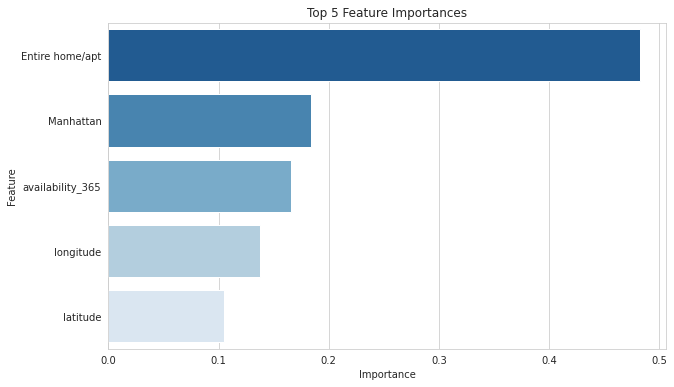

Training R^2: 0.8627027771410807
Testing R^2: 0.5979645650579053
Training Explained Variance Score: 0.8627027771410807
Testing Explained Variance Score: 0.59796673806634
Training Mean Absolute Error: 0.16541019569923998
Testing Mean Absolute Error: 0.2924560417147363
Training Mean Squared Error: 0.05154376099737613
Testing Mean Squared Error: 0.15443300298646703


In [ ]:
# Visualize feature importance using permutation importance
import seaborn as sns
from sklearn.inspection import permutation_importance

# Get feature importances
#importances = best_model_et.feature_importances_
result = permutation_importance(best_model_et, X_train, y_train, n_repeats=10, random_state=0)
importances = result.importances_mean
features = X_train.columns

# Create dataframe of feature importances
feature_importances = pd.DataFrame({'feature': features, 'importance': importances})

# Sort features by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot feature importances
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(5), palette='Blues_r')
plt.title('Top 5 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Print other evaluation metrics
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error

y_pred_train = best_model_et.predict(X_train)
y_pred_test = best_model_et.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

train_explained_variance = explained_variance_score(y_train, y_pred_train)
test_explained_variance = explained_variance_score(y_test, y_pred_test)

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

print("Training R^2:", train_r2)
print("Testing R^2:", test_r2)
print("Training Explained Variance Score:", train_explained_variance)
print("Testing Explained Variance Score:", test_explained_variance)
print("Training Mean Absolute Error:", train_mae)
print("Testing Mean Absolute Error:", test_mae)
print("Training Mean Squared Error:", train_mse)
print("Testing Mean Squared Error:", test_mse)


### Gradient Boost

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df2[features], target, test_size=0.2, random_state=10)

# Initialize model
gb_model = GradientBoostingRegressor(random_state = 27)

# Define hyperparameters for grid search
# Define the parameter grid
params = {'max_depth': [5, 7, 10],
              'n_estimators': np.arange(150, 170, 10),
              'learning_rate': [0.1, 0.12, 0.14]}

# Perform grid search to find best hyperparameters
grid_search = GridSearchCV(gb_model, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model_gb = grid_search.best_estimator_
print('(best_model:',best_model_gb)
best_params = grid_search.best_params_

# Fit best model to data
best_model_gb.fit(X_train, y_train)

# Make predictions on test data
y_pred = best_model_gb.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("RMSE:", rmse)
print("R-squared:", r2)
print("Mean squared error:", mse)

# Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 160}
# RMSE: 0.38904297600332105
# R-squared: 0.6059789953937972
# Mean squared error: 0.15135443717752065

(best_model: GradientBoostingRegressor(max_depth=7, n_estimators=160, random_state=27)
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 160}
RMSE: 0.38886609988609905
R-squared: 0.6527007717188575
Mean squared error: 0.15121684364062554


In [ ]:
# Evaluate model performance on real price
mse = mean_squared_error(y_test.apply(lambda x: math.exp(x)), pd.Series(y_pred).apply(lambda x: math.exp(x)))
rmse = np.sqrt(mse)
r2 = r2_score(y_test.apply(lambda x: math.exp(x)), pd.Series(y_pred).apply(lambda x: math.exp(x)))

In [ ]:
print("RMSE:", rmse)
print("R-squared:", r2)
print("Mean squared error:", mse)

RMSE: 78.23699840335804
R-squared: 0.4827068977471177
Mean squared error: 6121.027919167049


In [ ]:
# Feature Importance
import seaborn as sns

# Get feature importances
importances = best_model.feature_importances_
features = X_train.columns

# Create dataframe of feature importances
feature_importances = pd.DataFrame({'feature': features, 'importance': importances})

# Sort features by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot feature importances
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(5), palette='Blues_r')
plt.title('Top 5 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

NameError: ignored

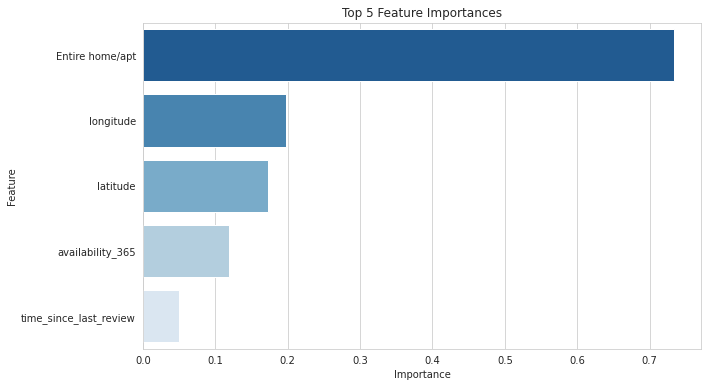

Training R^2: 0.7197028059669258
Testing R^2: 0.6059789953937972
Training Explained Variance Score: 0.7197028059669258
Testing Explained Variance Score: 0.6060418181008183
Training Mean Absolute Error: 0.24663001015967398
Testing Mean Absolute Error: 0.2898741592635513
Training Mean Squared Error: 0.10522843271434293
Testing Mean Squared Error: 0.15135443717752065


In [ ]:
# Visualize feature importance using permutation importance
import seaborn as sns
from sklearn.inspection import permutation_importance

# Get feature importances
result = permutation_importance(best_model_gb, X_train, y_train, n_repeats=10, random_state=0)
importances = result.importances_mean
features = X_train.columns

# Create dataframe of feature importances
feature_importances = pd.DataFrame({'feature': features, 'importance': importances})

# Sort features by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot feature importances
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(5), palette='Blues_r')
plt.title('Top 5 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Print other evaluation metrics
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error

y_pred_train = best_model_gb.predict(X_train)
y_pred_test = best_model_gb.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

train_explained_variance = explained_variance_score(y_train, y_pred_train)
test_explained_variance = explained_variance_score(y_test, y_pred_test)

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

print("Training R^2:", train_r2)
print("Testing R^2:", test_r2)
print("Training Explained Variance Score:", train_explained_variance)
print("Testing Explained Variance Score:", test_explained_variance)
print("Training Mean Absolute Error:", train_mae)
print("Testing Mean Absolute Error:", test_mae)
print("Training Mean Squared Error:", train_mse)
print("Testing Mean Squared Error:", test_mse)


# Other Boosting Algorithms

## CatBoost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df2[features], target, test_size=0.2, random_state=10)

In [ ]:
cat_params = {'depth': [7, 8, 9, 10, 11],
             'iterations': np.arange(270,320,10),
             'learning_rate': [0.14, 0.15, 0.16]}

cat_model = CatBoostRegressor(random_state = 27)

grid_search = GridSearchCV(cat_model, param_grid=cat_params, cv=3, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

In [ ]:
best_model = CatBoostRegressor(learning_rate = 0.15, iterations = 280, depth = 8, verbose = False, random_state=27)

best_model.fit(X_train, y_train)

# Make predictions on test data
y_pred = best_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [ ]:
print("RMSE:", rmse)
print("R-squared:", r2)
print("Mean squared error:", mse)

RMSE: 0.3896900339314351
R-squared: 0.6512274892243155
Mean squared error: 0.151858322545483


In [ ]:
# Evaluate model performance on real price
mse = mean_squared_error(y_test.apply(lambda x: math.exp(x)), pd.Series(y_pred).apply(lambda x: math.exp(x)))
rmse = np.sqrt(mse)
r2 = r2_score(y_test.apply(lambda x: math.exp(x)), pd.Series(y_pred).apply(lambda x: math.exp(x)))

In [ ]:
print("RMSE:", rmse)
print("R-squared:", r2)
print("Mean squared error:", mse)

RMSE: 78.70889618169069
R-squared: 0.47644782182443035
Mean squared error: 6195.090338140164


## XGBoost

In [ ]:
xgb_params = {'max_depth': [3, 4, 5, 6, 7, 8],
             'n_estimators': np.arange(200,300,10),
             'learning_rate': [0.05, 0.06, 0.07, 0.08]}

xgb_model = xgb.XGBRegressor(random_state = 27)

grid_search = GridSearchCV(xgb_model, param_grid=xgb_params, cv=3, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

In [ ]:
best_model = xgb.XGBRegressor(learning_rate=0.08, max_depth=7, n_estimators=250, random_state=27)

# Fit best model to data
best_model.fit(X_train, y_train)

# Make predictions on test data
y_pred = best_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R-squared:", r2)
print("Mean squared error:", mse)

RMSE: 0.3882499497758055
R-squared: 0.6538004763615624
Mean squared error: 0.1507380235009155


In [ ]:
# Evaluate model performance on real price
mse = mean_squared_error(y_test.apply(lambda x: math.exp(x)), pd.Series(y_pred).apply(lambda x: math.exp(x)))
rmse = np.sqrt(mse)
r2 = r2_score(y_test.apply(lambda x: math.exp(x)), pd.Series(y_pred).apply(lambda x: math.exp(x)))

In [ ]:
print("RMSE:", rmse)
print("R-squared:", r2)
print("Mean squared error:", mse)

RMSE: 78.32614399250922
R-squared: 0.4815273875058751
Mean squared error: 6134.9848327352875


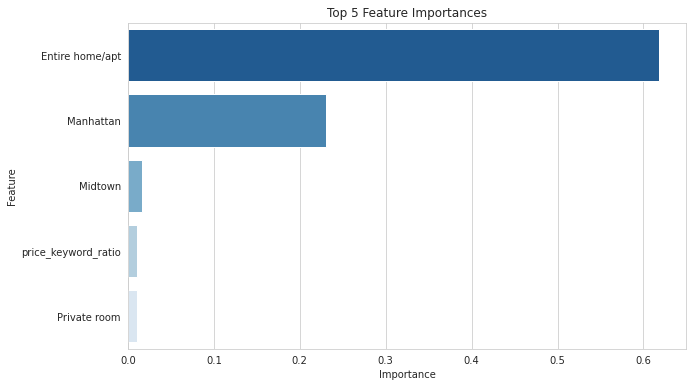

In [ ]:
# Feature Importance
import seaborn as sns

# Get feature importances
importances = best_model.feature_importances_
features = X_train.columns

# Create dataframe of feature importances
feature_importances = pd.DataFrame({'feature': features, 'importance': importances})

# Sort features by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot feature importances
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(5), palette='Blues_r')
plt.title('Top 5 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## AdaBoost

In [ ]:
ab_params = {'n_estimators': np.arange(50,150,10),
             'learning_rate': [0.08, 0.09, 0.1, 0.15, 0.2],
             'loss': ['linear', 'square', 'exponential']}

ab_model = AdaBoostRegressor(random_state = 27)

grid_search = GridSearchCV(ab_model, param_grid=ab_params, cv=3, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

In [ ]:
# Adaboost with estimator best Decision Tree
best_model = AdaBoostRegressor(estimator = DecisionTreeRegressor(ccp_alpha=0, max_depth=8, min_samples_leaf=4, random_state=42),learning_rate=0.1, loss='exponential', n_estimators=60, random_state=27)

best_model.fit(X_train, y_train)

# Make predictions on test data
y_pred = best_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R-squared:", r2)
print("Mean squared error:", mse)

RMSE: 0.40758382402020704
R-squared: 0.6184622372627474
Mean squared error: 0.16612457360293512


In [ ]:
# Evaluate model performance on real price
mse = mean_squared_error(y_test.apply(lambda x: math.exp(x)), pd.Series(y_pred).apply(lambda x: math.exp(x)))
rmse = np.sqrt(mse)
r2 = r2_score(y_test.apply(lambda x: math.exp(x)), pd.Series(y_pred).apply(lambda x: math.exp(x)))

In [ ]:
print("RMSE:", rmse)
print("R-squared:", r2)
print("Mean squared error:", mse)

RMSE: 81.50371975729554
R-squared: 0.43860674933086485
Mean squared error: 6642.856334275767


In [ ]:
# Adaboost with best CatBoost
best_model = AdaBoostRegressor(estimator = CatBoostRegressor(learning_rate = 0.15, iterations = 280, depth = 8, random_state=42),learning_rate=0.1, loss='exponential', n_estimators=60, random_state=27)

best_model.fit(X_train, y_train)

# Make predictions on test data
y_pred = best_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

Streaming output truncated to the last 5000 lines.
40:	learn: 0.5764089	total: 1.13s	remaining: 6.61s
41:	learn: 0.5755722	total: 1.15s	remaining: 6.52s
42:	learn: 0.5739087	total: 1.18s	remaining: 6.53s
43:	learn: 0.5731783	total: 1.21s	remaining: 6.47s
44:	learn: 0.5724004	total: 1.22s	remaining: 6.39s
45:	learn: 0.5716583	total: 1.24s	remaining: 6.3s
46:	learn: 0.5709515	total: 1.27s	remaining: 6.28s
47:	learn: 0.5700799	total: 1.28s	remaining: 6.2s
48:	learn: 0.5686841	total: 1.32s	remaining: 6.25s
49:	learn: 0.5680191	total: 1.34s	remaining: 6.17s
50:	learn: 0.5672785	total: 1.35s	remaining: 6.08s
51:	learn: 0.5662106	total: 1.38s	remaining: 6.04s
52:	learn: 0.5644675	total: 1.39s	remaining: 5.97s
53:	learn: 0.5630673	total: 1.41s	remaining: 5.91s
54:	learn: 0.5621027	total: 1.43s	remaining: 5.85s
55:	learn: 0.5606582	total: 1.45s	remaining: 5.79s
56:	learn: 0.5599898	total: 1.47s	remaining: 5.75s
57:	learn: 0.5582535	total: 1.49s	remaining: 5.71s
58:	learn: 0.5567376	total: 1.52s

In [ ]:
print("RMSE:", rmse)
print("R-squared:", r2)
print("Mean squared error:", mse)

RMSE: 0.3912934632533949
R-squared: 0.6483514465365414
Mean squared error: 0.1531105743848359


In [ ]:
# Adaboost with best XGBoost
best_model = AdaBoostRegressor(estimator = xgb.XGBRegressor(learning_rate=0.08, max_depth=7, n_estimators=250, random_state=27),learning_rate=0.1, loss='exponential', n_estimators=60, random_state=27)

best_model.fit(X_train, y_train)

# Make predictions on test data
y_pred = best_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R-squared:", r2)
print("Mean squared error:", mse)

RMSE: 0.38881484797140853
R-squared: 0.6527923126242551
Mean squared error: 0.1511769860030295


# Stack Models

In [ ]:
base_models = [
    ('CatBoost', CatBoostRegressor(learning_rate = 0.15, iterations = 280, depth = 8, random_state=27, verbose = False)),
    ('XGBoost',xgb.XGBRegressor(learning_rate=0.08, max_depth=7, n_estimators=250, random_state=27)),
    ('Random Forest',RandomForestRegressor(n_estimators=240, max_features = 0.7, max_depth = 10, min_samples_split = 5, random_state=27))
    ]

stacked = StackingRegressor(
    estimators = base_models,
    final_estimator = CatBoostRegressor(learning_rate = 0.15, iterations = 280, depth = 8, random_state=27, verbose = False),
    cv = 5)

for name, model in base_models:
    start_time = time.time()
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    end_time = time.time()
    
    r2 = model.score(X_test, y_test)
    rmse = mean_squared_error(y_test, prediction, squared = False)
    
    print("-------{}-------".format(name))
    print("Coefficient of determination: {}".format(r2))
    print("Root Mean Squared Error: {}".format(rmse))
    print("Computation Time: {}".format(end_time - start_time))
    print("----------------------------------\n")
start_time = time.time()
stacked.fit(X_train, y_train)    
stacked_prediction = stacked.predict(X_test)
end_time = time.time()
stacked_r2 = stacked.score(X_test, y_test)
stacked_rmse = mean_squared_error(y_test, stacked_prediction, squared = False)
print("-------Stacked Ensemble-------")
print("Coefficient of determination: {}".format(stacked_r2))
print("Root Mean Squared Error: {}".format(stacked_rmse))
print("Computation Time: {}".format(end_time - start_time))
print("----------------------------------")

-------Bagging-------
Coefficient of determination: 0.6166339897863287
Root Mean Squared Error: 0.40855918430682836
Computation Time: 70.59940481185913
----------------------------------

-------XGBoost-------
Coefficient of determination: 0.6538004763615624
Root Mean Squared Error: 0.3882499497758055
Computation Time: 20.640446662902832
----------------------------------

-------Random Forest-------
Coefficient of determination: 0.6379771784705688
Root Mean Squared Error: 0.39702344154333497
Computation Time: 47.29242992401123
----------------------------------

-------Stacked Ensemble-------
Coefficient of determination: 0.6497492610498485
Root Mean Squared Error: 0.39051498670176316
Computation Time: 684.0057418346405
----------------------------------


In [ ]:
base_models = [('Bagging', BaggingRegressor(estimator=DecisionTreeRegressor(ccp_alpha=0, max_depth=8, min_samples_leaf=4, random_state=27), 
                           n_estimators=300, 
                           max_samples=1.0, 
                           max_features=1.0, 
                           bootstrap=True, 
                           bootstrap_features=True,
                           random_state=42)),
    ('Adaboost', AdaBoostRegressor(estimator = DecisionTreeRegressor(ccp_alpha=0, max_depth=8, min_samples_leaf=4, random_state=42),learning_rate=0.1, loss='exponential', n_estimators=60, random_state=27)),
    ('CatBoost', CatBoostRegressor(learning_rate = 0.15, iterations = 280, depth = 8, random_state=27, verbose = False)),
    ('XGBoost',xgb.XGBRegressor(learning_rate=0.08, max_depth=7, n_estimators=250, random_state=27)),
    ('Random Forest',RandomForestRegressor(n_estimators=240, max_features = 0.3, max_depth = 20, min_samples_split = 5, random_state=27))
    ]
stacked = StackingRegressor(
    estimators = base_models,
    cv = 5)

start_time = time.time()
stacked.fit(X_train, y_train)    
stacked_prediction = stacked.predict(X_test)
end_time = time.time()
stacked_r2 = stacked.score(X_test, y_test)
stacked_rmse = mean_squared_error(y_test, stacked_prediction, squared = False)
print("-------Stacked Ensemble-------")
print("Coefficient of determination: {}".format(stacked_r2))
print("Root Mean Squared Error: {}".format(stacked_rmse))
print("Computation Time: {}".format(end_time - start_time))
print("----------------------------------")

-------Stacked Ensemble-------
Coefficient of determination: 0.6614989881826714
Root Mean Squared Error: 0.3839088827853125
Computation Time: 753.0655572414398
----------------------------------
